In [1]:
%matplotlib inline
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.manifold import TSNE

In [2]:
print(tf.__version__)

2.8.0


In [3]:
tf.config.list_physical_devices('GPU')

[]

In [4]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import EfficientNetB5
from tensorflow.keras.applications import EfficientNetV2S
from tensorflow.keras.applications.resnet50 import preprocess_input as ResNet_Pre
from tensorflow.keras.applications.resnet_v2 import preprocess_input as ResNetV2_Pre
from tensorflow.keras.applications.densenet import preprocess_input as DenseNet_Pre
from tensorflow.keras.applications.inception_v3 import preprocess_input as Inception_Pre
from tensorflow.keras.applications.xception import preprocess_input as Xception_Pre
from tensorflow.keras.applications.efficientnet import preprocess_input as EfficientNet_Pre

In [5]:
model_ResNet = ResNet50(weights="imagenet", include_top=False, pooling='avg', input_shape=(224, 224, 3))
model_ResNet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [6]:
# model_ResNetV2 = ResNet50V2(weights="imagenet", include_top=False, pooling='avg', input_shape=(224, 224, 3))
# model_ResNetV2.summary()

In [7]:
# model_DenseNet121 = DenseNet121(weights="imagenet", include_top=False, pooling='avg', input_shape=(224, 224, 3))
# model_DenseNet121.summary()

In [8]:
model_DenseNet201 = DenseNet201(weights="imagenet", include_top=False, pooling='avg', input_shape=(224, 224, 3))
model_DenseNet201.summary()

Model: "densenet201"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_2[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                        

In [9]:
# model_InceptionV3 = InceptionV3(weights="imagenet", include_top=False, pooling='avg', input_shape=(224, 224, 3))
# model_InceptionV3.summary()

In [10]:
# model_Xception = Xception(weights="imagenet", include_top=False, pooling='avg', input_shape=(224, 224, 3))
# model_Xception.summary()

In [11]:
# model_EfficientNetV2S = EfficientNetV2S(weights="imagenet", include_top=False, pooling='avg', input_shape=(224, 224, 3))
# model_EfficientNetV2S.summary()

In [12]:
model_EfficientNetB5 = EfficientNetB5(weights="imagenet", include_top=False, pooling='avg', input_shape=(224, 224, 3))
model_EfficientNetB5.summary()

Model: "efficientnetb5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_3[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 225, 225, 3)  0           ['normalization[0][0

In [13]:
# folder = "Power(ALLcroppedManual)"
folder = "VGGFlower"
q_batch_size = 30

q_directory = "D:\ExtraCources\SummerInter\FewShot\Test\QuerySets\FewShotQuery_" + folder

q_data = tf.keras.preprocessing.image_dataset_from_directory(
    q_directory,
    labels="inferred",
    label_mode="categorical",
    color_mode="rgb",
    batch_size=q_batch_size,
    image_size=(224, 224),
    shuffle=False,
    seed=42,
)

print(len(q_data))

Found 150 files belonging to 5 classes.
5


In [14]:
classes = ["2", "40", "57", "69", "89"]

tf.Tensor([0. 0. 0. 0. 1.], shape=(5,), dtype=float32)


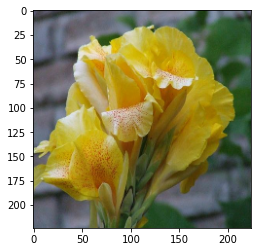

In [15]:
i = 0
for q in q_data.__iter__():
    if i != 4:
        i += 1
        continue
    
    j = 2
    
    plt.imshow(q[0][j] / 255)
    print(q[1][j])
    break

In [16]:
def make_conf_mat(model, q_full_features, q_labels):
    y_pred = tf.argmax(model.predict(q_full_features, batch_size=15, verbose=0), axis=1)
    y_true = tf.argmax(q_labels, axis=1)
    # test_scores = model.evaluate(q_full_features, q_labels, verbose=0)
    
    conf = tf.math.confusion_matrix(y_true, y_pred).numpy()
    
    con_mat_norm = np.around(conf.astype('float') / conf.sum(axis=1)[:, np.newaxis], decimals=2)

    conf_mat_df = pd.DataFrame(con_mat_norm, index = classes, columns = classes)
    
    figure = plt.figure(figsize=(8, 8))
    sns.set(font_scale=1.25)
    sns.heatmap(conf_mat_df, annot=True, cmap=plt.cm.Blues, annot_kws={"size":22})
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    # plt.title(test_scores)
    
    plt.show()

In [17]:
def make_model(input_size=(4, 4, 376), learning_rate=5e-4, nway=5, l2_regu_const=0.5):
    
    keras.backend.clear_session()
    model = keras.Sequential()
    
    model.add(keras.Input(shape=input_size))
    # 4, 4, 376 
    model.add(keras.layers.Conv2D(512,3,strides=(1, 1),padding="same",activation='relu'))
    # 4, 4, 512
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.AveragePooling2D(pool_size=4, strides=None, padding="valid"))
    # 1, 1, 512
    
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(512, activation='relu'))
    model.add(keras.layers.Dense(256, activation='relu'))
    model.add(keras.layers.Dense(32, activation='relu'))
    model.add(keras.layers.Dense(nway, kernel_regularizer=keras.regularizers.L2(l2_regu_const), activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), metrics=['accuracy'])
    
    return model

In [18]:
# arr = np.empty(32)
# k_fold = KFold(n_splits=32, shuffle=True, random_state=42)

# for train_indices, test_indices in k_fold.split(arr):
#     print('Train: %s | test: %s' % (len(train_indices), len(test_indices)))

Split number : 1
Epoch 1/300
1/1 [==============================] - 0s 494ms/step - loss: 5.6698 - accuracy: 0.1600
Epoch 2/300
1/1 [==============================] - 0s 29ms/step - loss: 5.1521 - accuracy: 1.0000
Epoch 3/300
1/1 [==============================] - 0s 28ms/step - loss: 4.7842 - accuracy: 1.0000
Epoch 4/300
1/1 [==============================] - 0s 29ms/step - loss: 4.4940 - accuracy: 1.0000
Epoch 5/300
1/1 [==============================] - 0s 29ms/step - loss: 4.2770 - accuracy: 1.0000
Epoch 6/300
1/1 [==============================] - 0s 29ms/step - loss: 4.1314 - accuracy: 1.0000
Epoch 7/300
1/1 [==============================] - 0s 30ms/step - loss: 4.0439 - accuracy: 1.0000
Epoch 8/300
1/1 [==============================] - 0s 30ms/step - loss: 3.9917 - accuracy: 1.0000
Epoch 9/300
1/1 [==============================] - 0s 29ms/step - loss: 3.9587 - accuracy: 1.0000
Epoch 10/300
1/1 [==============================] - 0s 29ms/step - loss: 3.9351 - accuracy: 1.0000
E

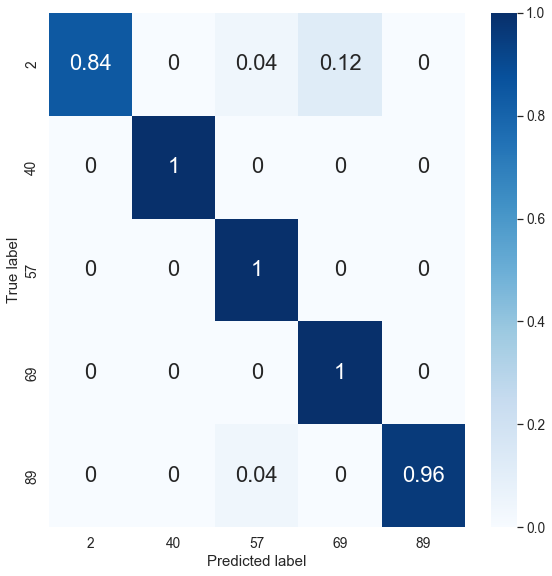

Split number : 2
Epoch 1/300
1/1 [==============================] - 0s 401ms/step - loss: 5.8107 - accuracy: 0.2400
Epoch 2/300
1/1 [==============================] - 0s 28ms/step - loss: 5.2340 - accuracy: 0.9200
Epoch 3/300
1/1 [==============================] - 0s 27ms/step - loss: 4.8440 - accuracy: 1.0000
Epoch 4/300
1/1 [==============================] - 0s 30ms/step - loss: 4.5655 - accuracy: 1.0000
Epoch 5/300
1/1 [==============================] - 0s 26ms/step - loss: 4.3707 - accuracy: 1.0000
Epoch 6/300
1/1 [==============================] - 0s 26ms/step - loss: 4.2412 - accuracy: 1.0000
Epoch 7/300
1/1 [==============================] - 0s 25ms/step - loss: 4.1586 - accuracy: 1.0000
Epoch 8/300
1/1 [==============================] - 0s 25ms/step - loss: 4.1070 - accuracy: 1.0000
Epoch 9/300
1/1 [==============================] - 0s 27ms/step - loss: 4.0733 - accuracy: 1.0000
Epoch 10/300
1/1 [==============================] - 0s 24ms/step - loss: 4.0492 - accuracy: 1.0000
E

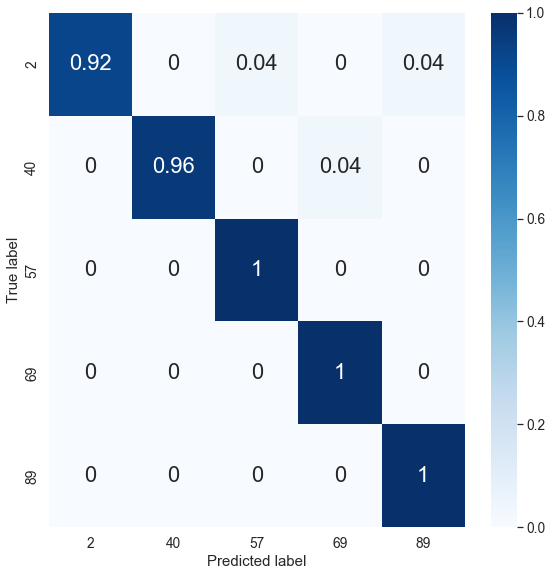

Split number : 3
Epoch 1/300
1/1 [==============================] - 0s 436ms/step - loss: 6.3864 - accuracy: 0.2400
Epoch 2/300
1/1 [==============================] - 0s 31ms/step - loss: 5.8329 - accuracy: 0.9200
Epoch 3/300
1/1 [==============================] - 0s 32ms/step - loss: 5.4500 - accuracy: 0.9600
Epoch 4/300
1/1 [==============================] - 0s 30ms/step - loss: 5.1862 - accuracy: 1.0000
Epoch 5/300
1/1 [==============================] - 0s 33ms/step - loss: 5.0160 - accuracy: 1.0000
Epoch 6/300
1/1 [==============================] - 0s 34ms/step - loss: 4.8993 - accuracy: 1.0000
Epoch 7/300
1/1 [==============================] - 0s 37ms/step - loss: 4.8175 - accuracy: 1.0000
Epoch 8/300
1/1 [==============================] - 0s 37ms/step - loss: 4.7569 - accuracy: 1.0000
Epoch 9/300
1/1 [==============================] - 0s 38ms/step - loss: 4.7103 - accuracy: 1.0000
Epoch 10/300
1/1 [==============================] - 0s 41ms/step - loss: 4.6730 - accuracy: 1.0000
E

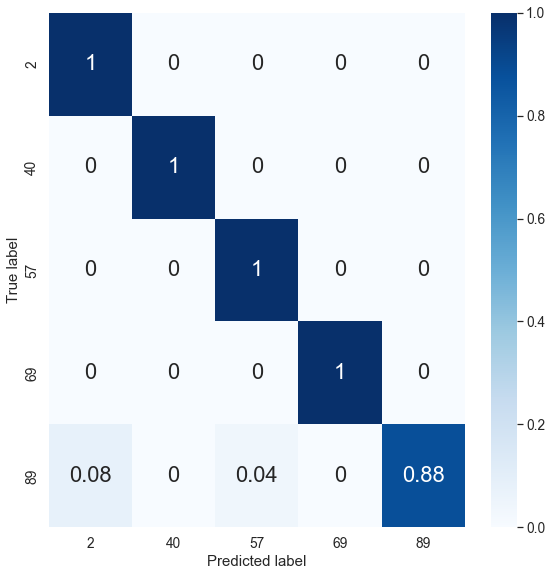

Split number : 4
Epoch 1/300
1/1 [==============================] - 0s 357ms/step - loss: 5.5128 - accuracy: 0.1200
Epoch 2/300
1/1 [==============================] - 0s 29ms/step - loss: 5.1187 - accuracy: 0.9600
Epoch 3/300
1/1 [==============================] - 0s 30ms/step - loss: 4.7416 - accuracy: 1.0000
Epoch 4/300
1/1 [==============================] - 0s 27ms/step - loss: 4.4192 - accuracy: 1.0000
Epoch 5/300
1/1 [==============================] - 0s 26ms/step - loss: 4.1812 - accuracy: 1.0000
Epoch 6/300
1/1 [==============================] - 0s 26ms/step - loss: 4.0239 - accuracy: 1.0000
Epoch 7/300
1/1 [==============================] - 0s 26ms/step - loss: 3.9191 - accuracy: 1.0000
Epoch 8/300
1/1 [==============================] - 0s 25ms/step - loss: 3.8494 - accuracy: 1.0000
Epoch 9/300
1/1 [==============================] - 0s 26ms/step - loss: 3.8025 - accuracy: 1.0000
Epoch 10/300
1/1 [==============================] - 0s 26ms/step - loss: 3.7700 - accuracy: 1.0000
E

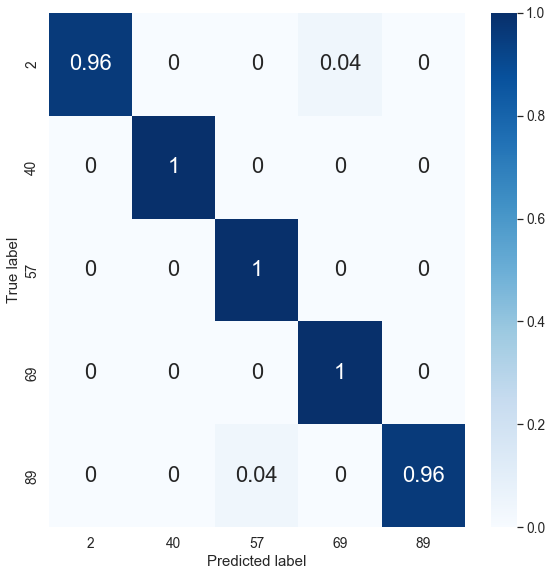

Split number : 5
Epoch 1/300
1/1 [==============================] - 0s 383ms/step - loss: 6.7367 - accuracy: 0.1200
Epoch 2/300
1/1 [==============================] - 0s 32ms/step - loss: 6.1883 - accuracy: 0.8000
Epoch 3/300
1/1 [==============================] - 0s 37ms/step - loss: 5.8323 - accuracy: 0.8400
Epoch 4/300
1/1 [==============================] - 0s 39ms/step - loss: 5.5911 - accuracy: 1.0000
Epoch 5/300
1/1 [==============================] - 0s 37ms/step - loss: 5.4168 - accuracy: 1.0000
Epoch 6/300
1/1 [==============================] - 0s 34ms/step - loss: 5.2839 - accuracy: 1.0000
Epoch 7/300
1/1 [==============================] - 0s 34ms/step - loss: 5.1801 - accuracy: 1.0000
Epoch 8/300
1/1 [==============================] - 0s 38ms/step - loss: 5.1011 - accuracy: 1.0000
Epoch 9/300
1/1 [==============================] - 0s 35ms/step - loss: 5.0411 - accuracy: 1.0000
Epoch 10/300
1/1 [==============================] - 0s 32ms/step - loss: 4.9958 - accuracy: 1.0000
E

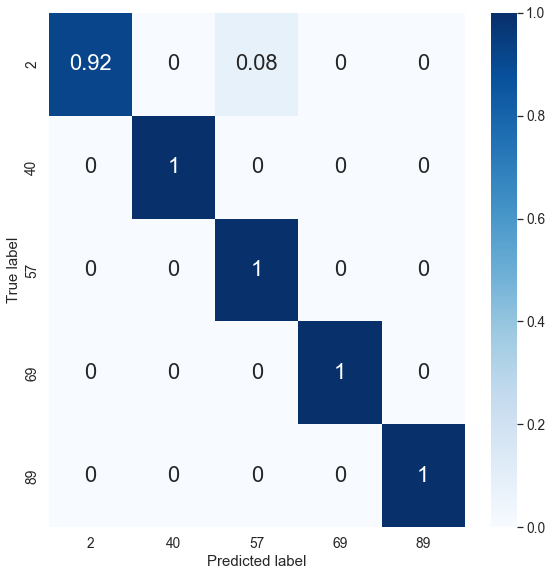

Split number : 6
Epoch 1/300
1/1 [==============================] - 0s 404ms/step - loss: 5.7187 - accuracy: 0.0800
Epoch 2/300
1/1 [==============================] - 0s 31ms/step - loss: 5.2884 - accuracy: 1.0000
Epoch 3/300
1/1 [==============================] - 0s 35ms/step - loss: 4.9323 - accuracy: 1.0000
Epoch 4/300
1/1 [==============================] - 0s 38ms/step - loss: 4.6091 - accuracy: 1.0000
Epoch 5/300
1/1 [==============================] - 0s 31ms/step - loss: 4.3526 - accuracy: 1.0000
Epoch 6/300
1/1 [==============================] - 0s 33ms/step - loss: 4.1768 - accuracy: 1.0000
Epoch 7/300
1/1 [==============================] - 0s 35ms/step - loss: 4.0685 - accuracy: 1.0000
Epoch 8/300
1/1 [==============================] - 0s 33ms/step - loss: 4.0033 - accuracy: 1.0000
Epoch 9/300
1/1 [==============================] - 0s 35ms/step - loss: 3.9623 - accuracy: 1.0000
Epoch 10/300
1/1 [==============================] - 0s 37ms/step - loss: 3.9345 - accuracy: 1.0000
E

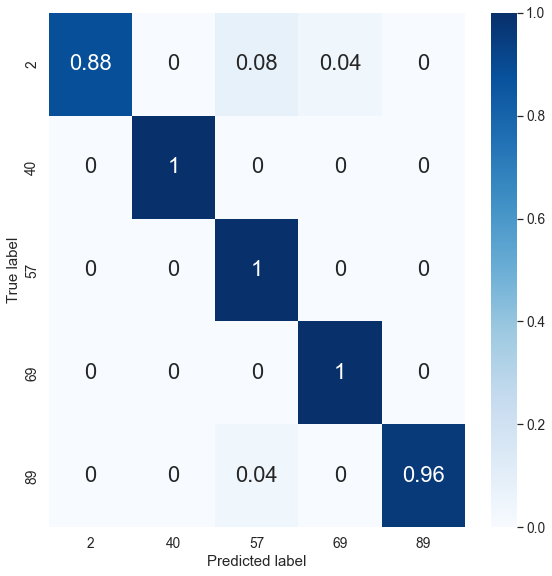

In [19]:
k = 0
running_acc = 0


arr = np.empty(30)
k_fold = KFold(n_splits=6, shuffle=True, random_state=42)

for train_indices, test_indices in k_fold.split(arr):
    
    k += 1
    
    # if k != 4:
    #     continue
    
    print("Split number : {}".format(k))
    
    # print('Train: %s | test: %s' % (train_indices, test_indices))

    sup_set = None
    sup_lab = None
    
    q_set = None
    q_lab = None
    
    
    for q in q_data.__iter__():
           
        temp_sup = tf.gather(q[0], test_indices)
        temp_sup_lab = tf.gather(q[1], test_indices)
        
        temp_q = tf.gather(q[0], train_indices)
        temp_q_lab = tf.gather(q[1], train_indices)
        
        if sup_set is None:
            sup_set = temp_sup
        else:
            sup_set = tf.concat([sup_set, temp_sup], 0)
        
        if sup_lab is None:
            sup_lab = temp_sup_lab
        else:
            sup_lab = tf.concat([sup_lab, temp_sup_lab], 0)
            
        if q_set is None:
            q_set = temp_q
        else:
            q_set = tf.concat([q_set, temp_q], 0)
            
        if q_lab is None:
            q_lab = temp_q_lab
        else:
            q_lab = tf.concat([q_lab, temp_q_lab], 0)
        
    
    # break
    

    channels = 376
    size = 4

    img_pre_res = ResNet_Pre(sup_set)
    res_features = model_ResNet(img_pre_res)
    
    # img_pre_resv2 = ResNet_Pre(sup_set)
    # resv2_features = model_ResNet(img_pre_resv2)    
    
    # img_pre_dense = DenseNet_Pre(sup_set)
    # dense_features121 = model_DenseNet121(img_pre_dense)
    
    img_pre_dense = DenseNet_Pre(sup_set)
    dense_features201 = model_DenseNet201(img_pre_dense)
    
    # img_pre_inception = Inception_Pre(sup_set)
    # inception_features = model_InceptionV3(img_pre_inception)
    
    # img_pre_xception = Xception_Pre(sup_set)
    # xception_features = model_Xception(img_pre_xception)
    
    # img_pre_efficientv2s = EfficientNet_Pre(sup_set)
    # efficientv2s_features = model_EfficientNetV2S(img_pre_efficientv2s)
    
    img_pre_efficientb5 = EfficientNet_Pre(sup_set)
    efficientb5_features = model_EfficientNetB5(img_pre_efficientb5)
    
    
    full_features = tf.concat([res_features, dense_features201, efficientb5_features], axis=1)
    
    # full_features = efficientb5_features
    
    labels = sup_lab
    
    
    
    q_img_res_pre = ResNet_Pre(q_set)
    q_res_features = model_ResNet(q_img_res_pre)
    
    # q_img_resv2_pre = ResNet_Pre(q_set)
    # q_resv2_features = model_ResNet(q_img_resv2_pre)
    
    # q_img_dense_pre = DenseNet_Pre(q_set)
    # q_dense_features121 = model_DenseNet121(q_img_dense_pre)
    
    q_img_dense_pre = DenseNet_Pre(q_set)
    q_dense_features201 = model_DenseNet201(q_img_dense_pre)
    
    # q_img_inception_pre = Inception_Pre(q_set)
    # q_inception_features = model_InceptionV3(q_img_inception_pre)
    
    # q_img_xception_pre = Xception_Pre(q_set)
    # q_xception_features = model_Xception(q_img_xception_pre)
    
    # q_img_efficientv2s_pre = EfficientNet_Pre(q_set)
    # q_efficientv2s_features = model_EfficientNetV2S(q_img_efficientv2s_pre)
    
    q_img_efficientb5_pre = EfficientNet_Pre(q_set)
    q_efficientb5_features = model_EfficientNetB5(q_img_efficientb5_pre)
    
    
    q_full_features = tf.concat([q_res_features, q_dense_features201, q_efficientb5_features], axis=1)
    
    # q_full_features = q_efficientb5_features
    
    q_labels = q_lab
    
    
    # break
    
    conv_ini = tf.reshape(full_features, (len(test_indices)*5,size, size, channels))
    
    q_conv_ini = tf.reshape(q_full_features, (len(train_indices)*5, size, size, channels))
    
    # break
    
    model = make_model(input_size=(size, size, channels))
    
    
    epochs = 300
    batch_size = 5 * 5
    
    history = model.fit(conv_ini, labels, batch_size=batch_size, epochs=epochs, validation_split=0, verbose=1, shuffle=False)
    
    test_scores = model.evaluate(q_conv_ini, q_labels, verbose=0)
    

    running_acc += test_scores[1]
    
    print("Accuracy on query set for split number {} is : {}".format(k, test_scores[1]))
    print("Average accuracy till now is : {}".format(running_acc / k))
    
    make_conf_mat(model, q_conv_ini, q_labels)

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 4, 4, 512)         1733120   
                                                                 
 batch_normalization (BatchN  (None, 4, 4, 512)        2048      
 ormalization)                                                   
                                                                 
 average_pooling2d (AverageP  (None, 1, 1, 512)        0         
 ooling2D)                                                       
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dense_1 (Dense)             (None, 256)               1

In [21]:
# Omniglot
# 0.9866666793823242

# Traffic
# 0.9312547104699271

# Aircraft
# 0.5866666436195374

# FC100
# 0.9057142904826573

# Texture
# 0.8200000013623919

# VGG Flower
# 0.9746666749318441

In [22]:
# 0.7011 5 way 1 shot
# 0.9229 5 way 5 shot
# 0.9562 5 way 10 shot

In [23]:
# 0.8483371223722186 RN-50 DN-121 I-V3 32*32 r-114
# 0.8138699957302639 RN-50 DN-121 I-V3 32*32 r-49

# 0.8786092315401349 RN-50 32*32
# 0.8657218473298209 RN-50 16*16
# 0.8553287982940674 RN-50 8*8
# 0.8824641108512878 RN-50 4*4 -----

# 0.8232426302773612 RN-50V2 32*32
# 0.857445205960955 RN-50V2 16*16
# 0.8628117953027997 RN-50V2 8*8
# 0.8948979548045567 RN-50V2 4*4

# 0.7639077816690717 DN-121 32*32
# 0.784769458430154 DN-121 16*16
# 0.7777021953037807 DN-121 8*8
# 0.8422524673598153 DN-121 4*4

# 0.6467498115130833 I-V3 32*32
# 0.6386621338980538 I-V3 16*16
# 0.6902494345392499 I-V3 8*8
# 0.7537036878722054 I-V3 4*4

# 0.7548374874251229 X 32*32
# 0.7173847300665719 X 16*16
# 0.7393801893506732 X 8*8
# 0.7827286379677909 X 4*4

# 0.7883597952978951 EN-V2S 16*16
# 0.7856764963694981 EN-V2S 8*8
# 0.8279289432934352 EN-V2S 4*4

# 0.7756991641862052 EN-B5 32*32
# 0.7977324213300433 EN-B5 16*16
# 0.7591458814484733 EN-B5 8*8
# 0.8276643923350743 EN-B5 4*4

# 0.790400607245309 DN-201 8*8
# 0.87535902432033 DN-201 4*4 ---



# 0.8556689364569527 RN-50 DN-201 8*8
# 0.8939531445503235 RN-50 DN-201 4*4

# 0.8567649466650826 DN-201 EN-B5 8*8
# 0.9012471692902702 DN-201 EN-B5 4*4

# 0.8877928938184466 RN-50 EN-B5 8*8
# 0.9095238191740853 RN-50 EN-B5 4*4

# !!
# 0.8774754319872174 RN-50 DN-201 EN-B5 8*8 with CNN 32
# 0.9023053646087646 RN-50 DN-201 EN-B5 4*4 with CNN 32
# !!

# 0.8752456477710179 RN-50 DN-201 EN-B5 8*8 with CNN 512
# 0.9229780861309597 RN-50 DN-201 EN-B5 4*4 with CNN 512

In [24]:
y_pred = tf.argmax(model.predict(q_conv_ini, batch_size=15, verbose=1), axis=1)
y_true = tf.argmax(q_labels, axis=1)
uneq = (y_pred != y_true).numpy()
# print(uneq)
e = [i for i in range(len(uneq)) if uneq[i] == True]
# print(e)
print(len(e))

9/9 [==============================] - 0s 5ms/step
4


In [25]:
# # i = 7
# for i in range(len(e)):
#     plt.figure()
#     plt.axis("off")
#     plt.imshow(q_set[e[i]] / 255)
#     plt.title("Predicted : {}\nActual : {}".format(classes[y_pred[e[i]]], classes[y_true[e[i]]]))
    
#     # print("Predicted : {}".format(classes[y_pred[e[i]]]))
#     # print("Actual : {}".format(classes[y_true[e[i]]]))

['2', '40', '57', '69', '89']


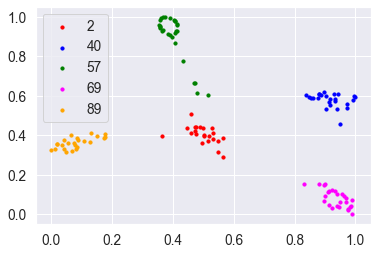

In [26]:
model2 = tf.keras.Model(inputs=model.input, outputs=model.layers[-2].output)
# test_ds = np.concatenate(list(train_ds.take(5).map(lambda x, y : x))) # get five batches of images and convert to numpy array

q_features2 = model2(q_conv_ini)
labels = tf.argmax(model.predict(q_conv_ini, batch_size=15, verbose=0), axis=1)
tsne = TSNE(n_components=2, learning_rate="auto", init="random").fit_transform(q_features2)

def scale_to_01_range(x):

    value_range = (np.max(x) - np.min(x))
    starts_from_zero = x - np.min(x)
    return starts_from_zero / value_range

tx = tsne[:, 0]
ty = tsne[:, 1]

tx = scale_to_01_range(tx)
ty = scale_to_01_range(ty)

colors = ['red', 'blue', 'green', 'magenta', 'orange']
# classes = q_full_features.class_names  
print(classes)
fig = plt.figure()
ax = fig.add_subplot(111)
for idx, c in enumerate(colors):
    indices = [i for i, l in enumerate(labels) if idx == l]
    current_tx = np.take(tx, indices)
    current_ty = np.take(ty, indices)
    ax.scatter(current_tx, current_ty, s=10, c=c, label=classes[idx])

ax.legend(loc='best')
plt.show()

In [27]:
def print_plots(history):
        
  plt.figure()
  plt.plot(history.history['accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train'], loc='upper right')
  plt.show()

  plt.figure()
  plt.plot(history.history['loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train'], loc='upper right')
  plt.show()

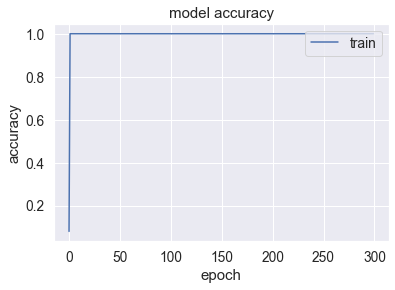

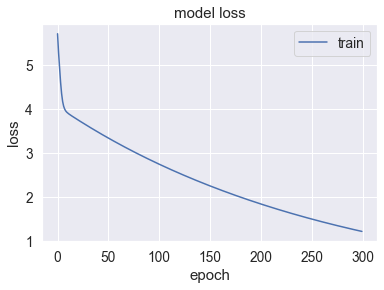

In [28]:
print_plots(history)

In [29]:
# model.save("D:\ExtraCources\SummerInter\FewShot\Test\SavedModels\TF_conv_model_RN_DN_EN")